In [87]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [88]:
ds = pd.read_csv('datasets/cleaned/merged_fx_dataset.csv')

In [89]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  3703 non-null   object 
 1   Buying                3703 non-null   float64
 2   Selling               3701 non-null   float64
 3   MidRate               3701 non-null   float64
 4   MPR                   3703 non-null   float64
 5   FoodInflation         3703 non-null   float64
 6   GhInflationRate       3703 non-null   float64
 7   NonFoodInflation      3703 non-null   float64
 8   BrentOil              3703 non-null   float64
 9   Cocoa                 3703 non-null   float64
 10  Gold                  3703 non-null   float64
 11  GhInterestRate        3703 non-null   float64
 12  NetForeignAssets      3703 non-null   float64
 13  NIR                   3703 non-null   float64
 14  Imports               3703 non-null   float64
 15  Exports              

In [90]:
ds.describe()

,Buying,Selling,MidRate,MPR,FoodInflation,GhInflationRate,NonFoodInflation,BrentOil,Cocoa,Gold,...,GhCompositeIndex,FXDeposits,InterbankWeightedAvg,T-bill-182,T-bill-91,PrivateSectorCredit,TradeBalance,USGDP,USInflationRate,USInterestRate
count,3703.000000,3701.000000,3701.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,...,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000,3703.000000
mean,3.530772,3.544903,3.538283,17.566298,9.406992,13.162123,15.904580,78.275919,2605.203195,1376.505611,...,10.724850,12890.848739,17.692960,18.781812,18.092925,23971.175385,-91.865903,18832.657882,97.836017,0.675963
std,2.075334,2.067895,2.071712,3.887258,7.649873,6.548326,6.722725,26.067664,364.240950,293.762486,...,14.042634,11516.004255,4.783674,5.994375,5.712537,16068.639877,259.873020,1767.190952,7.435416,0.884789
min,0.000000,0.000000,0.000000,12.500000,-1.630000,4.670000,6.740000,26.625700,1904.600000,760.800000,...,-10.470000,1127.980000,6.350000,9.900000,9.250000,3336.900000,-733.060000,16269.145000,87.093000,0.040000
25%,1.506600,1.540600,1.521500,14.500000,5.330000,8.640000,11.210000,56.000000,2324.818200,1200.700000,...,2.920000,3791.390000,13.570000,13.830000,13.190000,7943.450000,-262.620000,17035.114000,91.570000,0.090000
50%,3.779600,3.783400,3.781500,16.000000,7.350000,11.410000,14.240000,74.800000,2555.860000,1305.800000,...,6.220000,11166.070000,16.840000,16.190000,15.510000,24659.580000,-108.860000,18782.243000,96.882000,0.160000
75%,5.082800,5.087900,5.085400,19.000000,11.470000,16.910000,20.570000,105.810000,2897.600000,1658.500000,...,13.900000,18305.780000,22.110000,24.620000,23.070000,33986.980000,88.000000,20304.874000,103.058000,1.160000
max,13.099100,13.112300,13.105700,27.000000,59.700000,54.100000,49.900000,134.800000,3430.400000,1971.069500,...,73.360000,66496.630000,25.800000,36.230000,35.480000,73744.050000,666.990000,22249.459000,116.977000,4.270000


In [91]:
df = ds.drop(columns=['MidRate', 'Selling'])

In [92]:
df['Buying'] = df['Buying'].replace(0, np.nan)
df['Buying'] = df['Buying'].interpolate()

In [94]:
# df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True, errors='coerce')

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  3703 non-null   datetime64[ns]
 1   Buying                3703 non-null   float64       
 2   MPR                   3703 non-null   float64       
 3   FoodInflation         3703 non-null   float64       
 4   GhInflationRate       3703 non-null   float64       
 5   NonFoodInflation      3703 non-null   float64       
 6   BrentOil              3703 non-null   float64       
 7   Cocoa                 3703 non-null   float64       
 8   Gold                  3703 non-null   float64       
 9   GhInterestRate        3703 non-null   float64       
 10  NetForeignAssets      3703 non-null   float64       
 11  NIR                   3703 non-null   float64       
 12  Imports               3703 non-null   float64       
 13  Exports           

In [96]:
df = df.set_index('Date').sort_index()

In [97]:
# 1. Extract the Buying price series
buying_series = df['Buying']

In [99]:
buying_series.tail()

Date
2022-11-25    13.0985
2022-11-28    13.0982
2022-11-29    13.0980
2022-11-30    13.0978
2022-12-01    13.0973
Name: Buying, dtype: float64

ADF Statistic: 3.3634
p-value: 1.0000
Critical Value 1%: -3.4321
Critical Value 5%: -2.8623
Critical Value 10%: -2.5672

After 1 differencing(s):
ADF Statistic: -5.7878
p-value: 0.0000

Number of differences (d) needed for stationarity: 1


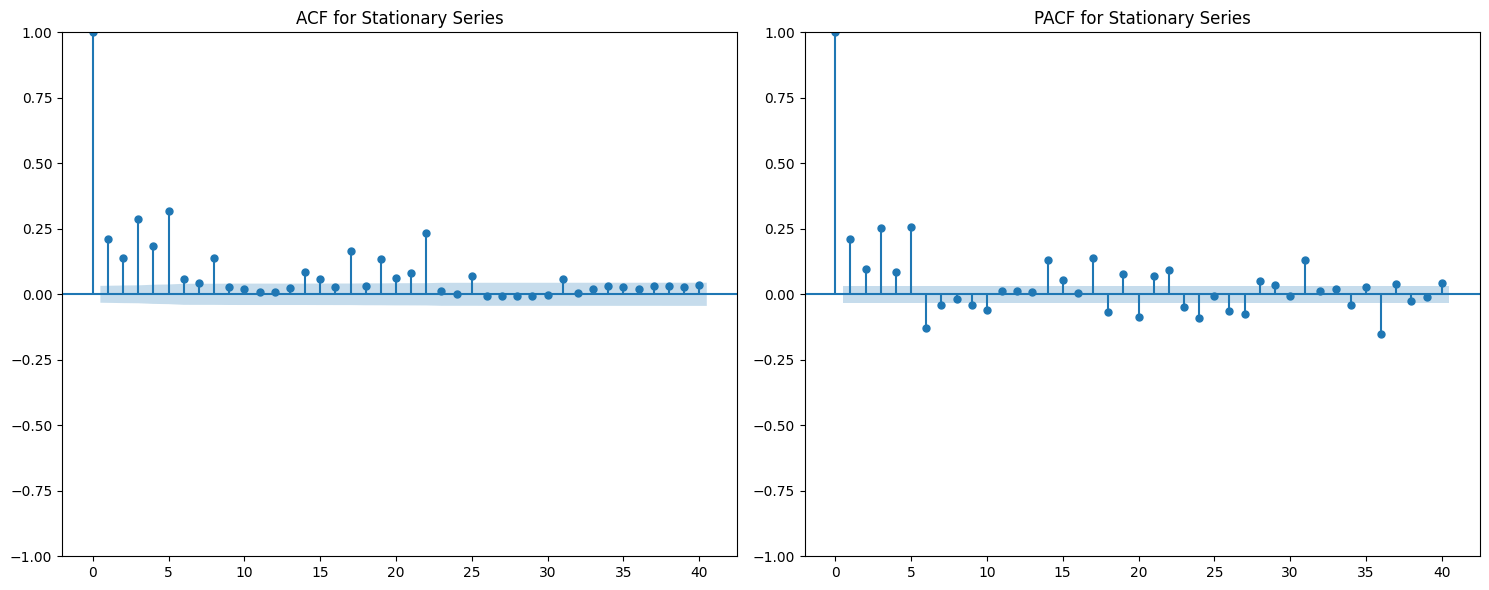

In [100]:
# 2. Test for stationarity using the Augmented Dickey-Fuller test
adf_result = adfuller(buying_series.dropna())
print("ADF Statistic: {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value:.4f}')

# 3. If not stationary, difference the series until stationary
stationary_series = buying_series.copy()
d = 0
while adfuller(stationary_series.dropna())[1] > 0.05:
    stationary_series = stationary_series.diff().dropna()
    d += 1
    adf_test_post = adfuller(stationary_series)
    print(f'\nAfter {d} differencing(s):')
    print("ADF Statistic: {:.4f}".format(adf_test_post[0]))
    print("p-value: {:.4f}".format(adf_test_post[1]))

print(f"\nNumber of differences (d) needed for stationarity: {d}")

# 4. Plot ACF and PACF
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_acf(stationary_series, ax=plt.gca(), lags=40,
         title='ACF for Stationary Series')
plt.subplot(1, 2, 2)
plot_pacf(stationary_series, ax=plt.gca(), lags=40,
          method='ywm', title='PACF for Stationary Series')
plt.tight_layout()
# plt.savefig('plots/arima/acf_pacf_plot.png')
plt.show()

In [101]:
# 5. Build ARIMA Model (choose p, d, q based on ACF/PACF or as example p=1, q=1)
p = 1
q = 1
arima_model = ARIMA(buying_series, order=(p, d, q))
arima_result = arima_model.fit()

In [102]:
print(f'The value of p={p}, q={q} and d={d}')

The value of p=1, q=1 and d=1


In [103]:
# 6. Model Summary
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Buying   No. Observations:                 3703
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7468.790
Date:                Sat, 25 Oct 2025   AIC                         -14931.580
Time:                        11:19:11   BIC                         -14912.930
Sample:                             0   HQIC                        -14924.943
                               - 3703                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9065      0.004    224.698      0.000       0.899       0.914
ma.L1         -0.7562      0.006   -128.537      0.000      -0.768      -0.745
sigma2         0.0010   1.76e-06    589.602      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   2.39   Jarque-Bera (JB):          69701808.39
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):             297.66   Skew:                            21.36
Prob(H) (two-sided):                  0.00   Kurtosis:                       673.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
# Predict for the last 20% of the data using integer indexes
number_of_observations = len(buying_series)
start_index = int(number_of_observations * 0.8)
end_index = number_of_observations - 1

In [105]:
# predictions
arima_predictions = arima_result.predict(start=start_index, end=end_index)

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

In [107]:
arima_mae = mean_absolute_error(
    buying_series[-len(arima_predictions):], arima_predictions)
arima_mse = mean_squared_error(
    buying_series[-len(arima_predictions):], arima_predictions)
# arima_rmse = np.sqrt(arima_mse)
arima_rmse = root_mean_squared_error(
    buying_series[-len(arima_predictions):], arima_predictions)
arima_r2 = r2_score(
    buying_series[-len(arima_predictions):], arima_predictions)

results_df = pd.DataFrame({
    'Model': ['ARIMA'],
    'MAE': [arima_mae],
    'MSE': [arima_mse],
    'RMSE': [arima_rmse],
    'R2': [arima_r2]
})

In [108]:
results_df

,Model,MAE,MSE,RMSE,R2
0,ARIMA,0.013137,0.004731,0.06878,0.998293


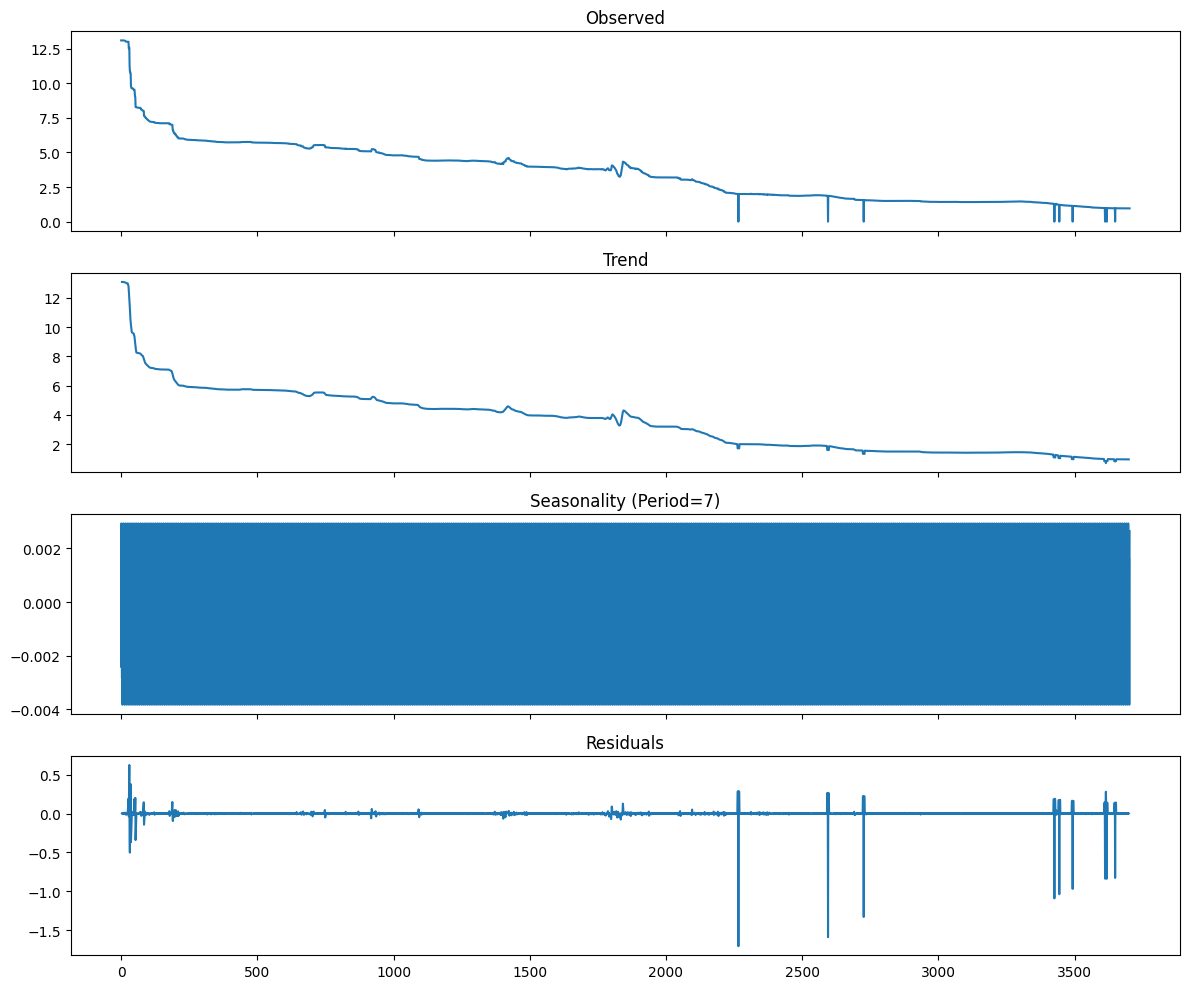

In [109]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = ds['Buying']
decomposition = seasonal_decompose(ts, model='additive', period=7)

# 5. Plot decomposition components
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality (Period=7)')
decomposition.resid.plot(ax=axes[3], title='Residuals')
plt.tight_layout()
# plt.savefig('seasonal_decomposition.png')
plt.show()

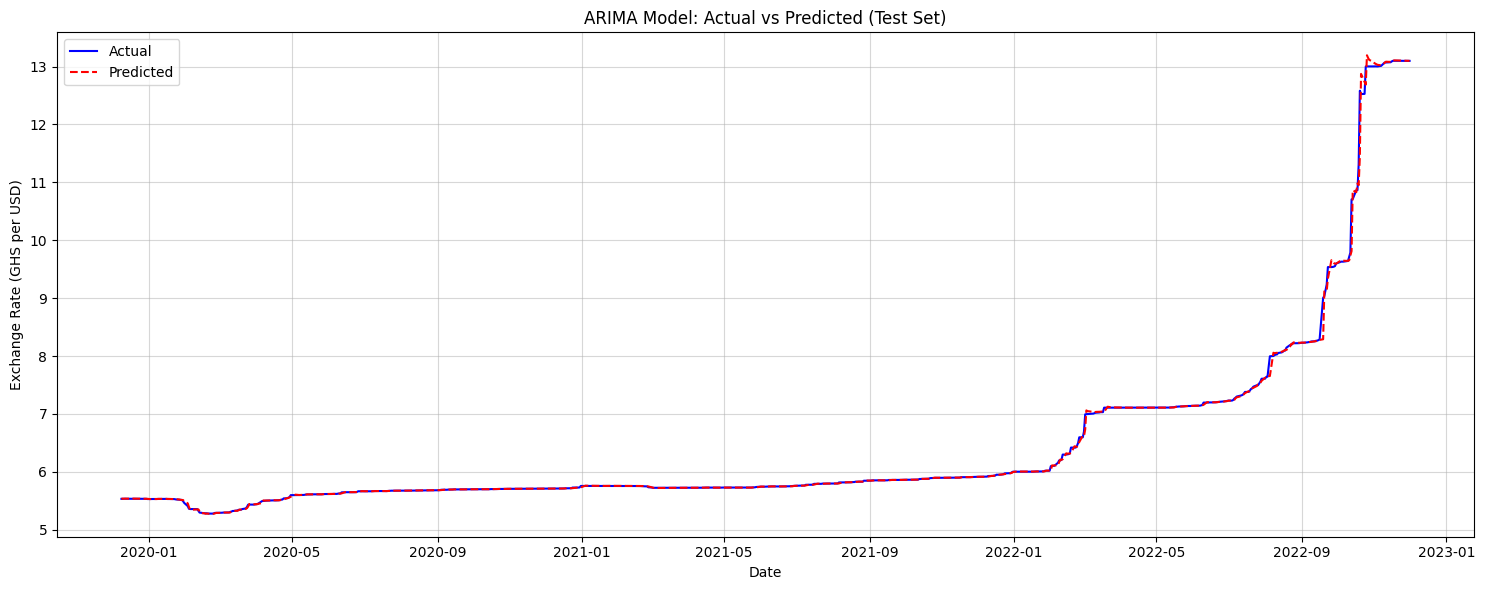

In [110]:
# Plot actual vs predicted values for ARIMA model predictions on test set
plt.figure(figsize=(15, 6))

# Actual values (last 20%)
actual = buying_series[-len(arima_predictions):]

# Predicted values
predicted = arima_predictions

# Align index
plot_index = actual.index

plt.plot(plot_index, actual, label='Actual', color='blue')
plt.plot(plot_index, predicted, label='Predicted', linestyle='--', color='red')
plt.title('ARIMA Model: Actual vs Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (GHS per USD)')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
# plt.savefig('plots/arima/arima_actual_predicted.png')
plt.show()

In [ ]:
import pmdarima as pm

# Run auto_arima on the buying series (ignore missing values)
auto_arima_model = pm.auto_arima(
    buying_series,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    seasonal=False,  # If you want seasonal set to True and specify m
    d=None,          # Let auto_arima select the order of differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("Best ARIMA order selected by auto_arima:", auto_arima_model.order)
print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4372.198, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3966.630, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3460.359, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4370.198, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3325.352, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3310.013, Time=0.59 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3739.582, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3290.222, Time=0.95 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3609.463, Time=0.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3305.480, Time=0.93 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3168.301, Time=2.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3316.583, Time=0.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3168.135, Time=2.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3297.952, Time=2.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

In [117]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model using the best order found by auto_arima
best_order = auto_arima_model.order
arima_best = ARIMA(buying_series, order=best_order)
arima_best_result = arima_best.fit()

# Get in-sample predictions (one-step-ahead)
predictions = arima_best_result.predict(start=buying_series.index[0], end=buying_series.index[-1])

In [112]:
best_order

(2, 1, 3)

In [113]:
# Compute metrics
mae = mean_absolute_error(buying_series, predictions)
mse = mean_squared_error(buying_series, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(buying_series, predictions)

# Create DataFrame with metrics
m_df = pd.DataFrame({
    'Model': ['ARIMA'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R2': [r2]
})

m_df

,Model,MAE,MSE,RMSE,R2
0,ARIMA,0.006201,0.001214,0.034847,0.999717
